In [1]:
import src.generation.gamma as ga
import src.generation.multivariate_normal as mn

from src.salp.salp import SALP
from src.salp.salp import Node

from src.algorithms.round_robin import RoundRobin
from src.algorithms.best_fit import BestFit

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# funkcja do produkowania wykresów obciążenia węzłów

def plot_node_load(n: Node, estimated_node_load: float = None, actual_mean_node_load: float = None, node_power: float = None):
    size = n.ws.size
    plt.bar(
        np.arange(size),
        n.ws
    )
    plt.title("Node {}".format(n.identity))
    if estimated_node_load:
        plt.hlines(estimated_node_load, xmin=0-1, xmax=size, colors='r')
    if actual_mean_node_load:
        plt.hlines(actual_mean_node_load, xmin=0-1, xmax=size, colors='g', linestyle='dashed')
    if node_power:
        plt.hlines(node_power, xmin=0-1, xmax=size, colors='orange')
    plt.show()

In [3]:
from typing import List

def calculate_total_node_queueing_time(n: Node, power: float) -> float:
    stb = np.mean(n.ws)/power
    assert stb < 1, "Node {} is not stable".format(n.identity)
    coeff = stb/(1-stb)
    return coeff * np.sum(n.ws)
    
def calculate_all_nodes_queueing_time(nodes: List[Node], power: float) -> float:
    total_ct = 0
    for n in nodes:
        ct = calculate_total_node_queueing_time(n, power)
        total_ct += ct
    return total_ct

In [4]:
# TODO algorithms
# SALP
def salp_wrapper(N: int, load_vectors):
    return SALP(N, load_vectors, False)
# Best Fit
def bf_wrapper(N: int, load_vectors):
    return None
# Round robin
def rr_wrapper(N: int, load_vectors):
    return RoundRobin(N, load_vectors, False)

algorithms = [
    ('SALP', salp_wrapper),
#     ('BF', bf_wrapper),
    ('RR', rr_wrapper),
]

## Example pipeline

Estimated minimal node power 30.0
Node power 37.5
Actual mean node load 30.73833083879031
-----------------------
Node 0: 0.8330989554140844 1559.4282331350855


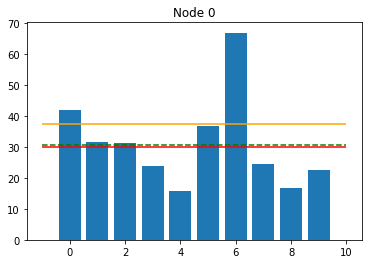

Node 1: 0.8356042521323023 1592.7293023954353


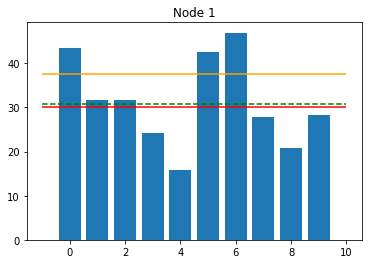

Node 2: 0.7747960317803364 999.608647454564


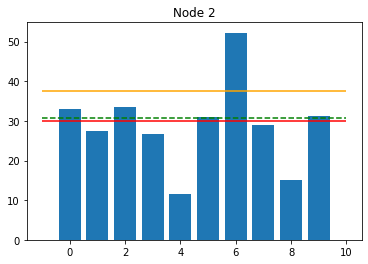

Node 3: 0.8352560501442443 1588.0385969714043


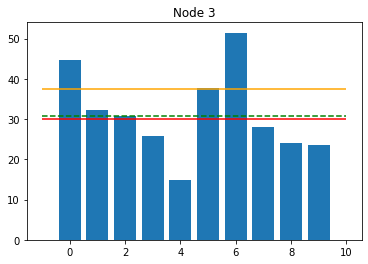

In [5]:
def pipeline(F: int, N: int, size: int, cor: float, ro: float, rng = (2,4)):
    
    generator = ga.Generator(F, size, cor, rng)
    
    estimated_load = generator.get_estimated_cloud_load()
    estimated_node_load = estimated_load/size/N
    print("Estimated minimal node power", estimated_node_load)
    
    node_power = estimated_node_load/ro
    print("Node power", node_power)
    
    load_vectors = generator.generate_cloud_load_vectors()
    actual_mean_node_load = np.sum(load_vectors)/size/N
    print("Actual mean node load", actual_mean_node_load)
    
    cloud = SALP(N, load_vectors, False)
    assert len(cloud.nodes) == N
    
    print('-----------------------')
    
    for n in cloud.nodes:
        ct = calculate_total_node_queueing_time(n, node_power)
        print("Node {}:".format(n.identity), np.mean(n.ws)/node_power, ct)
        plot_node_load(n,estimated_node_load,actual_mean_node_load, node_power)
    
    
pipeline(20, 4, 10, 0.5, 0.8)

### Walidacja SALP

----------------DESCRIPTION----------------
Shards:
[[3 1]
 [3 1]
 [3 1]
 [1 3]
 [1 3]
 [1 3]]

WTS:
[12 12]

NWTS:
[6. 6.]

LW:
[(0, 3.1622776601683795), (1, 3.1622776601683795), (2, 3.1622776601683795), (3, 3.1622776601683795), (4, 3.1622776601683795), (5, 3.1622776601683795)]


----------------ASSIGNMENT----------------
Shard ID: 0
Shard: [3 1]

	Node ID: 0
	Delta: 2.654329479393269

	Node ID: 1
	Delta: 2.654329479393269

Shard ID: 1
Shard: [3 1]

	Node ID: 0
	Delta: 1.8309518948453007

	Node ID: 1
	Delta: 2.654329479393269

Shard ID: 2
Shard: [3 1]

	Node ID: 0
	Delta: 1.8309518948453007

	Node ID: 1
	Delta: 1.8309518948453007

Shard ID: 3
Shard: [1 3]

	Node ID: 0
	Delta: 2.585786437626905

	Node ID: 1
	Delta: 3.0025247700991105

Shard ID: 4
Shard: [1 3]

	Node ID: 0
	Delta: 2.585786437626905

	Node ID: 1
	Delta: 1.4142135623730951

Shard ID: 5
Shard: [1 3]

	Node ID: 1
	Delta: 1.4142135623730951

----------------FINAL NODES----------------
Node: 0
	Shards assigned [FS]: [0 2 4]
	

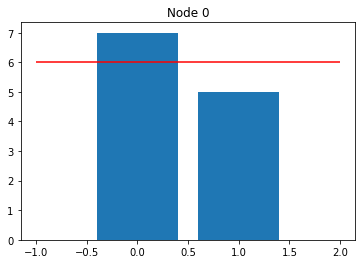

Node 1: 1.0


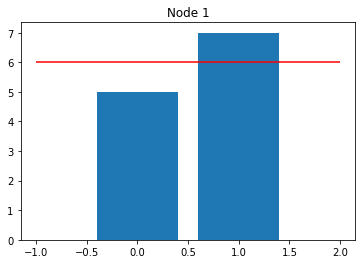

In [6]:
N = 2 # try with n=3 <3
size = 2
instance = np.array([[3,1],[3,1],[3,1],[1,3],[1,3],[1,3]])
cloud = SALP(N,instance, True)
load = np.sum(instance)
mean_node_load = load/N/size

for n in cloud.nodes:
    # stabilność
    print("Node {}:".format(n.identity), np.mean(n.ws)/mean_node_load)
    plot_node_load(n, mean_node_load)

### Walidacja RR

Shard 0 [3 1] to Node 0 node lw [3. 1.]
Shard 1 [3 1] to Node 1 node lw [3. 1.]
Shard 2 [3 1] to Node 0 node lw [6. 2.]
Shard 3 [1 3] to Node 1 node lw [4. 4.]
Shard 4 [1 3] to Node 0 node lw [7. 5.]
Shard 5 [1 3] to Node 1 node lw [5. 7.]
Node 0: 1.0


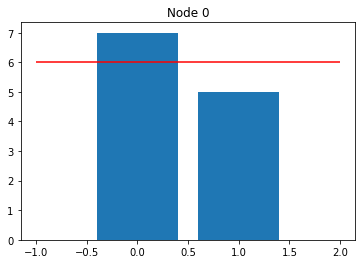

Node 1: 1.0


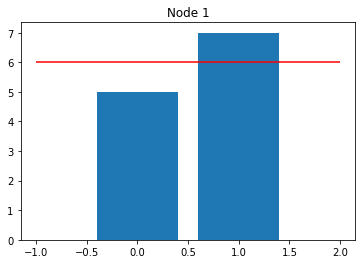

In [7]:
N = 2 # try with n=3 <3
size = 2
instance = np.array([[3,1],[3,1],[3,1],[1,3],[1,3],[1,3]])
cloud = RoundRobin(N,instance, True)
load = np.sum(instance)
mean_node_load = load/N/size

for n in cloud.nodes:
    # stabilność
    print("Node {}:".format(n.identity), np.mean(n.ws)/mean_node_load)
    plot_node_load(n, mean_node_load)

### Walidacja Best Fit

6.0
[(0, 2.0), (1, 2.0), (2, 2.0), (3, 2.0), (4, 2.0), (5, 2.0)]
all asigned
Node 0: 1.0


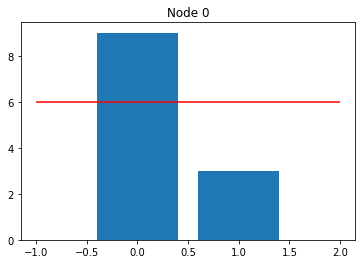

Node 1: 1.0


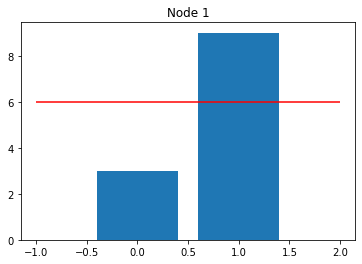

In [8]:
def best_fit2(n: int, shards: np.ndarray):
    
    node_mean_load = np.sum(shards) / n / shards.shape[1]
    print(node_mean_load)
    
    nodes = [Node(e) for e in range(0, n)]
    ss = [(i, v) for i, v in enumerate(np.mean(shards, axis=1)) ]
    ss.sort(key=lambda x: x[1], reverse=True)
    usd = [False for _ in range(len(ss))]
    print(ss)
    
    tolerance = node_mean_load * 0.1 # zakładamy, ze node może zostać przepełniony o 10%
    for node in nodes:
        for i, m in ss:
            if usd[i]:
                continue
            nl = np.mean(node.ws)
            if nl + m < node_mean_load + tolerance:
                node.shard_append(i, shards[i])
                usd[i] = True
            if all(usd):
                print("all asigned")
                break
    if not all(usd):
        print("Error")
        # TODO assign remaining nodes with first fit
    return nodes

N = 2
size = 2
instance = np.array([[3,1],[3,1],[3,1],[1,3],[1,3],[1,3]])
mean_node_load = load/N/size
nds = best_fit2(N, instance)

for n in nds:
    print("Node {}:".format(n.identity), np.mean(n.ws)/mean_node_load)
    plot_node_load(n, mean_node_load)

# Parametry dla iteracji
* F - ilość shardów
* N - ilość węzłów
* cor - poziom korelacji miedzy wektorami obciążenia
* ro - poziom obciążenia chmury
* size - długość wektorów obciążenia
* repeats - ilość powtórzeń pojedynczej symulacji
* parametry generatora do ustalenia

In [9]:
N = 100
F = 10*N
cor_range = np.arange(0.0, 1.01, 0.5)
load_range = [0.8, 0.9]
size=100
repeats=5
rng = (2,4)

In [10]:
def gamma_generator_factory(cor):
    return ga.Generator(F, size, cor, rng)

In [11]:
# prototype
for cor in cor_range:
    
    generator = ga.Generator(F, size, cor, rng)
    
    estimated_load = generator.get_estimated_cloud_load()
    estimated_node_load = estimated_load/size/N
    print("Estimated node load", estimated_node_load)
    
    for ro in load_range:
        
        node_power = estimated_node_load/ro
        
        for _ in range(repeats):
            
            load_vectors = generator.generate_cloud_load_vectors()
            actual_mean_node_load = np.sum(load_vectors)/size/N
#             print("Actual mean node load", actual_mean_node_load)
            
            for name, func in algorithms:
                cloud = func(N, load_vectors)
                try:
                    total_ct = calculate_all_nodes_queueing_time(cloud.nodes, node_power)
                except AssertionError:
                    total_ct = -1
            
                print(cor, ro, name, total_ct)

Estimated node load 60.0
0.0 0.8 SALP 2314798.9759034826
0.0 0.8 RR 2587619.9943614
0.0 0.8 SALP 2299067.8027432654
0.0 0.8 RR 2567165.384851685
0.0 0.8 SALP 2312491.1669366355
0.0 0.8 RR 2608831.6245410307
0.0 0.8 SALP 2269035.9293144797
0.0 0.8 RR 2496921.1100505805
0.0 0.8 SALP 2341592.372949185
0.0 0.8 RR 2573015.2253898988
0.0 0.9 SALP 5311009.174493453
0.0 0.9 RR -1
0.0 0.9 SALP 5144268.370828274
0.0 0.9 RR -1
0.0 0.9 SALP 5128521.018912641
0.0 0.9 RR -1
0.0 0.9 SALP 5144300.603557801
0.0 0.9 RR -1
0.0 0.9 SALP 5213896.712795142
0.0 0.9 RR -1
Estimated node load 60.0
0.5 0.8 SALP 2363991.678221725
0.5 0.8 RR 2717013.8176827403
0.5 0.8 SALP 2395253.8951322054
0.5 0.8 RR 2800358.687078184
0.5 0.8 SALP 2383568.431992251
0.5 0.8 RR 2765572.6414090153
0.5 0.8 SALP 2407891.7151734517
0.5 0.8 RR 2768058.7648943313
0.5 0.8 SALP 2338785.482350137
0.5 0.8 RR 2678777.951002352
0.5 0.9 SALP 5183779.792564775
0.5 0.9 RR -1
0.5 0.9 SALP 5300916.242162615
0.5 0.9 RR -1
0.5 0.9 SALP 5379293.0811

In [12]:
from typing import Tuple, List, Callable
from src.generation.base.generator import BaseGenerator

def evaluate_algorithms(N: int, node_power: float, algorithms: List[Tuple[str, Callable]], load_vectors: np.ndarray):
    for name, func in algorithms:
        cloud = func(N, load_vectors)
        try:
            total_ct = calculate_all_nodes_queueing_time(cloud.nodes, node_power)
        except AssertionError:
            total_ct = -1
        yield name, total_ct
        
def pipeline(N: int, size: int, repeats: int, cor_range: List[float], load_range: List[float], generator_factory: Callable[[float], BaseGenerator], algotithms: List[Tuple[str, Callable]]):
    for cor in cor_range:
        generator = generator_factory(cor)
        
        estimated_load = generator.get_estimated_cloud_load()
        estimated_node_load = estimated_load/size/N
#         print("Estimated node load", estimated_node_load)
        
        for ro in load_range:
            node_power = estimated_node_load/ro
            
            for _ in range(repeats):
                load_vectors = generator.generate_cloud_load_vectors()
#                 print(np.sum(load_vectors)/size/N)
                
                for res in evaluate_algorithms(N, node_power, algorithms, load_vectors):
                    yield((cor, ro) + res)
                
for partial in pipeline(N, size, repeats, cor_range, load_range, gamma_generator_factory, algorithms):
    print(partial)

(0.0, 0.8, 'SALP', 2377840.458601756)
(0.0, 0.8, 'RR', 2645387.5854072534)
(0.0, 0.8, 'SALP', 2360907.8855184596)
(0.0, 0.8, 'RR', 2621019.8167996146)
(0.0, 0.8, 'SALP', 2375005.3653245657)
(0.0, 0.8, 'RR', 2649061.7938820454)
(0.0, 0.8, 'SALP', 2331036.3407559125)
(0.0, 0.8, 'RR', 2573689.5974715943)
(0.0, 0.8, 'SALP', 2398398.7180036698)
(0.0, 0.8, 'RR', 2669461.0644221175)
(0.0, 0.9, 'SALP', 5573559.871507007)
(0.0, 0.9, 'RR', -1)
(0.0, 0.9, 'SALP', 5325272.968658654)
(0.0, 0.9, 'RR', -1)
(0.0, 0.9, 'SALP', 5354539.622866274)
(0.0, 0.9, 'RR', -1)
(0.0, 0.9, 'SALP', 5298525.446269398)
(0.0, 0.9, 'RR', -1)
(0.0, 0.9, 'SALP', 5350096.117587304)
(0.0, 0.9, 'RR', -1)
(0.5, 0.8, 'SALP', 2356181.0015403302)
(0.5, 0.8, 'RR', 2662590.818789079)
(0.5, 0.8, 'SALP', 2360671.4269172885)
(0.5, 0.8, 'RR', 2654750.5827909713)
(0.5, 0.8, 'SALP', 2383409.281142406)
(0.5, 0.8, 'RR', 2646404.6752935853)
(0.5, 0.8, 'SALP', 2390705.2291435977)
(0.5, 0.8, 'RR', 2671916.450371593)
(0.5, 0.8, 'SALP', 233336

In [13]:
import pandas as pd

gen = pipeline(N, size, repeats, cor_range, load_range, gamma_generator_factory, algorithms)
df = pd.DataFrame(gen, columns=['correlation', 'load', 'algorithm', 'value'])

df.head()

,correlation,load,algorithm,value
0,0.0,0.8,SALP,2.361000e+06
1,0.0,0.8,RR,2.689225e+06
2,0.0,0.8,SALP,2.363611e+06
3,0.0,0.8,RR,2.627277e+06
4,0.0,0.8,SALP,2.361624e+06
